<a href="https://colab.research.google.com/github/Konstvv/DL_MRI_reconstriction/blob/main/MRI_main_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO list:
1. Find the dataset (High-quality MRI images)
* small dataset - https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
* large dataset - https://fastmri.med.nyu.edu/ (need to request the access)
* Something else?

2. Preprocess the data

 2.1 HQ images -> make them noisy

 * White noise - every pixel would get a SMALL random increment
 * Gaussian blur - https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html

 2.2 (maybe optional, depends on dataset size) Data augmentation
 * Rotation (saving the original size)
 * Zoom
 * Mirror

Training sample - pair of images (clean and corrupted images: label and sample)

3. Creation of the model

  * Supervised learning paradigm
  * Baseline model - CNN architecture (dims of input and output are the same)
  * Compare the output to the orginal image:
      * PSNR(Peak Signal-to-Noise Ratio)
      * SSIM
  * Overview of the models: https://arxiv.org/pdf/1912.13171.pdf
  * Brain MRI model: https://aapm.onlinelibrary.wiley.com/doi/epdf/10.1002/acm2.13758

  * General overview: https://towardsai.net/p/deep-learning/image-de-noising-using-deep-learning

4. Tuning and testing


In [ ]:
## Part 1
# Dataset import
# Upload it to Google Drive
# Fetch the data Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
!pip install fastmri
import h5py
import numpy as np
from matplotlib import pyplot as plt
import fastmri
from fastmri.data import transforms as T
import os
from fastmri.data.subsample import RandomMaskFunc
filepath = '/content/drive/MyDrive/multicoil_test/multicoil_test'
import cv2
from tensorflow.keras.datasets import mnist

TypeError: ignored

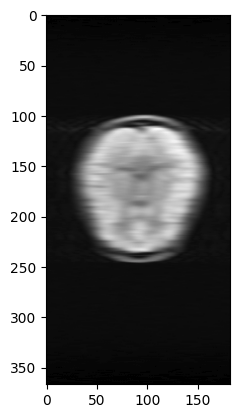

In [17]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for integer, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), integer + 1)
        plt.imshow(data[num], cmap=cmap)

real_images = []
for filename in os.listdir(filepath):


    file_name = os.path.join(filepath, filename)
    sz = os.stat(file_name)
    print(sz.st_size)
    hf = h5py.File(file_name, 'r')
    print('Keys:', list(hf.keys()))
    print('Attrs:', dict(hf.attrs))
    volume_kspace = hf['kspace'][()]
    print(volume_kspace.dtype)
    print(volume_kspace.shape)

    for i in range(0, volume_kspace.shape[0]):
        slice_kspace = volume_kspace[i]

        slice_kspace2 = T.to_tensor(slice_kspace)  # Convert from numpy array to pytorch tensor
        slice_image = fastmri.ifft2c(slice_kspace2)  # Apply Inverse Fourier Transform to get the complex image
        slice_image_abs = fastmri.complex_abs(slice_image)  # Compute absolute value to get a real image

        slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

        real_images.append(np.abs(slice_image_rss.numpy()))

        # mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object
        # masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)  # Apply the mask to k-space

        # sampled_image = fastmri.ifft2c(masked_kspace)  # Apply Inverse Fourier Transform to get the complex image
        # sampled_image_abs = fastmri.complex_abs(sampled_image)  # Compute absolute value to get a real image
        # sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

        # real_images.append(np.abs(sampled_image_rss.numpy()))  # Append the real image to the list


        print("Added")

for i in real_images:

    plt.imshow(i, cmap='gray')
    print(real_images[i])
    plt.show()

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast, RandomZoom

class NoiseLayer(tf.keras.layers.Layer):
  def __init__(self, noise_type='gauss'):
    super(NoiseLayer, self).__init__()
    self.noise_type = noise_type

  def build(self, input_shape):
    pass

  def call(self, inputs):
    if self.noise_type == "gauss":
        mean = 0
        var = 0.1
        gauss = np.random.normal(mean, var**0.5, inputs.shape)
        gauss = gauss.reshape(*inputs.shape)
        noisy = inputs + gauss
        return noisy
    elif self.noise_type == "poisson":
        peak = 5
        noisy = np.random.poisson(inputs * peak) / float(peak)
        return noisy

data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomZoom(0.1, fill_mode='nearest'),
    RandomRotation(0.2, fill_mode='nearest'),
    RandomContrast(0.3),
    NoiseLayer(noise_type='poisson')])

def noisy_data(real_images):
    real_images = [cv2.resize(img, (640, 320)) for img in real_images]

    augmented_images = data_augmentation(real_images)
    noisy_images = tf.clip_by_value(augmented_images, 0., 1.)

    return noisy_images

In [9]:
real_images = np.asarray(real_images).astype('float32') / 255.
# test_data = test_data.astype('float32') / 255.

noisy_images = noisy_data(real_images)
# noisy_test = noisy_data(test_data)

In [13]:
## Part 3
# Model architechture
# Keras to create baseline CNN model

from tensorflow.keras import layers
from tensorflow.keras.models import Model

input = layers.Input(shape=(320, 640, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 640, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 320, 640, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 160, 320, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 160, 320, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 80, 160, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 160, 320, 32)      9248

In [14]:
autoencoder.fit(
    x=noisy_images,
    y=real_images,
    epochs=50,
    batch_size=128,
    shuffle=True,
    # validation_data=(noisy_test, test_data),
)

Epoch 1/50


ValueError: ignored

In [ ]:
## Part 4
# Evaluation and testing